In [29]:
import sys
sys.path.append("..")

# basics
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import copy
import qutip.floquet as floq
import qutip

# custom stuff
import system.from_higher_basis_truncation_tunable_full_cosine as system
import utils.solver as solver
import pulse.tanh as tanh
import utils.expectation_values as expv
import utils.graph as graph
import utils.saver as saver
from tqdm import tqdm as tqdm

# parallel utils
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor

pass

In [36]:
amplitude = 1 * 2.5 * np.pi
ramp_slope = 0.5
cut_factor = 3

guess_offset = 0.13168831168831152
guess_duration = 80

In [32]:
# Find a good pulse to start with
offset_range_width = 1
tlist = np.linspace(0, guess_duration, int(guess_duration*5))
guess_fids = []
guess_offset_range = np.linspace(guess_offset-offset_range_width, guess_offset+offset_range_width)
for offset in tqdm(guess_offset_range):
    tanh.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tanh.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    guess_fids.append(fidelity)

100%|██████████| 50/50 [01:29<00:00,  1.80s/it]


0.13168831168831152

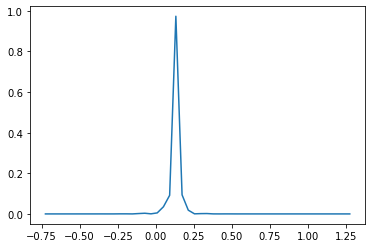

In [35]:
plt.plot(guess_offset_range, guess_fids)
plt.xlabel("frequency offset from initial guess")
plt.ylabel("fidelity")
plt.show()
guess_offset = guess_offset_range[np.argmax(guess_fids)]

In [37]:
# Find a good pulse to start with
def cost(parameters, constants):
    # parameters = [offset, duration]
    offset = parameters[0]
    duration = parameters[1]
    # constants = [amplitude, ramp_coeff]
    amplitude = constants[0]
    ramp_slope = constants[1]
    cut_factor = constants[2]
    tlist = np.linspace(0, duration, int(duration*5))
    tanh.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tanh.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    print(fidelity, offset, duration)
    return (1-fidelity)

result1 = sp.optimize.minimize(cost, [guess_offset, guess_duration], [amplitude, ramp_slope, cut_factor], method="Nelder-Mead", options={"disp":True})

t_max = result1.x[1]
offset = result1.x[0]
freq = system.first_energy_spacing/3 - offset
durations = np.arange(0, t_max, (2*np.pi)/(freq*20))

0.9734515169484416 0.13168831168831152 80.0
0.7256747136130192 0.1382727272727271 80.0
0.9767206660122941 0.13168831168831152 84.0
0.9200733577402499 0.12510389610389594 84.0
0.9953883523153214 0.12839610389610373 83.0
0.9877148893841508 0.12839610389610373 87.0
0.9104959469098752 0.12510389610389594 86.0
0.9974712475538078 0.13004220779220763 84.5
0.9937411791598354 0.1300422077922076 80.5
0.998761448775838 0.12963068181818163 82.125
0.9844887868464246 0.13127678571428553 83.625
0.9994384924225725 0.12911627435064918 83.15625
0.9943123510923622 0.12870474837662318 80.78125
0.9994484155087664 0.1297078429383115 83.5703125
0.9989004032019045 0.12919343547077908 84.6015625
0.9996308504748643 0.12930274705762973 83.982421875
0.998260514028332 0.12989431564529205 84.396484375
0.9998091265396081 0.1293107846743099 83.46630859375
0.9985926002177551 0.12890568879362813 83.87841796875
0.9998035520895425 0.12950730440214064 83.6473388671875
0.9997542818560936 0.1295153420188208 83.1312255859375

fidelity 0.9998828498723625


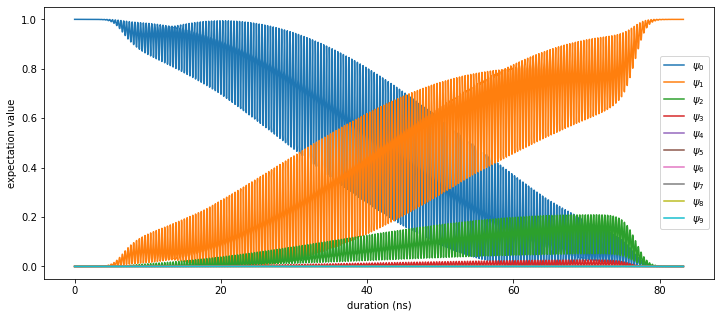

In [38]:
# Graph applied pulse

tanh.setup(amplitude, freq, ramp_slope, cut_factor, durations)

s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, durations, system.starting_state, pbar=True)

graph.graph_solution(s, system)
print("fidelity", expv.expectation_value(s.final_state, system.target_state))

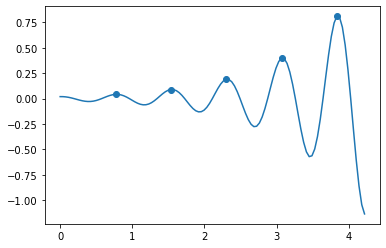

In [39]:
# Create list of points at peaks of pulse

dur_points = np.arange(0, t_max, (2*np.pi)/(freq))[::1]
dur_points = dur_points[1:-1]
pulse = tanh.get_pulse(durations)
num_of_points = 111
num_of_durPoints = 5

plt.plot(durations[:num_of_points], pulse[:num_of_points])
plt.scatter(dur_points[:num_of_durPoints], tanh.get_pulse(dur_points)[:num_of_durPoints])


In [40]:
# utility functions 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if np.amin(np.abs(array - value)) > 1e-12:
        print("error, duration does not exactly exist!", value, array[idx])
    return idx

def overlap(state1, state2):
    return (np.transpose(np.matrix(state1.full())) * np.matrix(state2.full())).item()

# generate floquet kets
kets = []
for dur in dur_points:
    dur_amp = tanh.pulse_func(dur)
    def steady(t, args=None):
        return dur_amp * np.cos(freq * t)
    H = [system.H0, [system.H1, steady]]

    floquet_kets, quasi_energies = floq.floquet_modes(H, (2*np.pi)/freq)
    kets.append(floquet_kets)

# sort floquet kets
sorted_kets = [np.array(kets[0]).reshape((10,10))]
for i in range(1, len(dur_points)):
    reshaped_ket = np.array(kets[i]).reshape((10,10))
    m = np.abs(np.dot( (sorted_kets[-1]), np.transpose(reshaped_ket)  ))**2
    row_ind, col_ind = sp.optimize.linear_sum_assignment(1-m)
    # print(col_ind)
    sorted_kets.append( reshaped_ket[col_ind] )

# find overlaps of sorted kets
overlaps = []
expectation_values = []
for i in range(len(dur_points)):
    ket = sorted_kets[i]
    dur = dur_points[i]
    index_of_dur = find_nearest(durations, dur)
    overlaps_at_this_dur = []
    expv_at_this_dur = []
    for k in ket:
        expv_at_this_dur.append(qutip.expect(qutip.ket2dm(s.states[index_of_dur]), qutip.Qobj(k)))
        overlaps_at_this_dur.append(overlap(s.states[index_of_dur], qutip.Qobj(k)))
    overlaps.append(np.array(overlaps_at_this_dur))
    expectation_values.append(np.array(expv_at_this_dur))

overlaps = np.transpose(np.array(overlaps))
expectation_values = np.transpose(np.array(expectation_values))

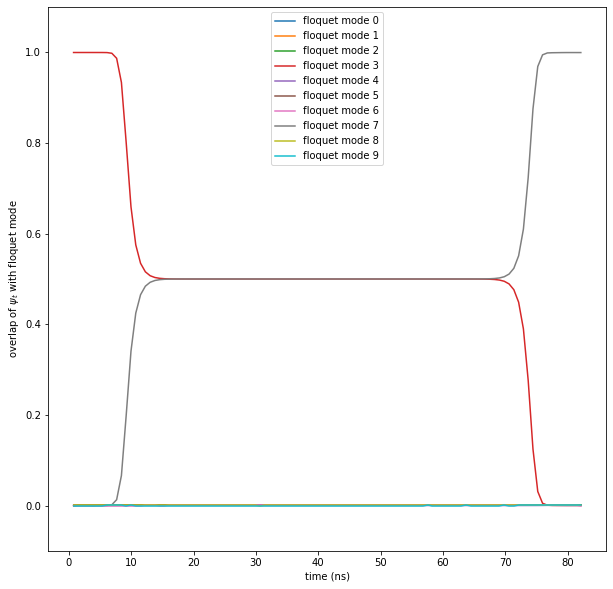

In [42]:
plt.figure(figsize=(10,10))
for i in range(0, len(expectation_values)):
    o = expectation_values[i]
    plt.plot(dur_points, o, label=r'floquet mode %i' % i)
# plt.plot(dur_points, overlaps, label=labeled_overlaps)
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel(r'overlap of $\psi_t$ with floquet mode')
plt.ylim((-0.1, 1.1))
plt.show()

/var/folders/8w/jht5wjcd4kl492xz8hs9lft40000gn/T/ipykernel_20298/390076438.py:22: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, azim=-40, elev=30)


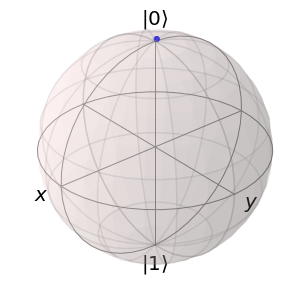

<Figure size 360x360 with 0 Axes>

In [18]:
# Generate Bloch Sphere Rotation

# xs = []
# ys = []
# zs = []
# overlaps = np.transpose(overlaps)
# for i in range(0, len(overlaps)):
#     c0 = overlaps[i,3]
#     c1 = overlaps[i,4]
#     xs.append( np.conjugate(c0) * c1 + c0 * np.conjugate(c1) )
#     ys.append( -1j * np.conjugate(c0) * c1 + 1j * c0 * np.conjugate(c1) )
#     zs.append( np.conjugate(c0) * c0 - c1 * np.conjugate(c1) )

#     # xs.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmax()))
#     # ys.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmay()))
#     # zs.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmaz()))
#     # vecs.append([xs[-1], ys[-1], zs[-1]])


# from matplotlib import pyplot, animation
# from mpl_toolkits.mplot3d import Axes3D

# fig = pyplot.figure()
# ax = Axes3D(fig, azim=-40, elev=30)
# sphere = qutip.Bloch(axes=ax)

# def animate(i):
#     sphere.clear()
#     sphere.add_points([xs[i:i+1], ys[i:i+1], zs[i:i+1]])
#     sphere.make_sphere()
#     return ax

# def init():
#     sphere.vector_color = ['r']
#     return ax

# ani = animation.FuncAnimation(fig, animate, np.arange(len(xs)),
#                             init_func=init, blit=False, repeat=False)

# ani.save('%s_bloch_sphere.mp4' % "tanh_%f" % amp, fps=20)

In [ ]:
# Look at how much each floquet state occupies fock states during flat top driving